In [1]:
from spectral_cube import SpectralCube
import spectral_cube
print(spectral_cube.__version__)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
from astropy.io import fits
from reproject import reproject_interp
from astropy import wcs, units as u
results = '/blue/adamginsburg/abulatek/brick/first_results/continuum_images/'

0.6.6.dev107+g8320826


In [2]:
# Get list of all images
import glob
imagefns = glob.glob(f"{results}/brickmaser_cont_*_mtmfs_incl_adjparam*.image.tt0")

In [3]:
# Remove the whole-bandwidth versions of data_31 and data_41
imagefns.remove('/blue/adamginsburg/abulatek/brick/first_results/continuum_images/brickmaser_cont_data_31_mtmfs_incl_adjparam.image.tt0')
imagefns.remove('/blue/adamginsburg/abulatek/brick/first_results/continuum_images/brickmaser_cont_data_41_mtmfs_incl_adjparam.image.tt0')
imagefns

['/blue/adamginsburg/abulatek/brick/first_results/continuum_images/brickmaser_cont_data_41_mtmfs_incl_adjparam_split_first.image.tt0',
 '/blue/adamginsburg/abulatek/brick/first_results/continuum_images/brickmaser_cont_data_31_mtmfs_incl_adjparam_split_second.image.tt0',
 '/blue/adamginsburg/abulatek/brick/first_results/continuum_images/brickmaser_cont_data_55_mtmfs_incl_adjparam.image.tt0',
 '/blue/adamginsburg/abulatek/brick/first_results/continuum_images/brickmaser_cont_data_59_mtmfs_incl_adjparam.image.tt0',
 '/blue/adamginsburg/abulatek/brick/first_results/continuum_images/brickmaser_cont_data_51_mtmfs_incl_adjparam.image.tt0',
 '/blue/adamginsburg/abulatek/brick/first_results/continuum_images/brickmaser_cont_data_41_mtmfs_incl_adjparam_split_second.image.tt0',
 '/blue/adamginsburg/abulatek/brick/first_results/continuum_images/brickmaser_cont_data_5d_mtmfs_incl_adjparam.image.tt0',
 '/blue/adamginsburg/abulatek/brick/first_results/continuum_images/brickmaser_cont_data_31_mtmfs_incl

In [12]:
# Import the continuum images
contimages = []
for imagefn in imagefns:
    image = SpectralCube.read(imagefn, format='casa_image')
    # image = image.to(u.K) # We'd rather have Jy/beam because we're dealing with point sources
    contimages.append(image)
# Reorder continuum images from lowest to highest frequency
lowestfreqs = [np.min(contimage.spectral_axis).value for contimage in contimages]
correct_order = np.argsort(lowestfreqs)
contimages_ordered = [contimages[i] for i in correct_order]
# Calculate common beam
import radio_beam
beams = [contimage.beam for contimage in contimages_ordered]
beams = radio_beam.Beams(beams=beams)
common_beam = beams.common_beam()
common_beam
# Convert all images to a common beamsize
contimages_ordered_cb = [contimage.convolve_to(common_beam) for contimage in contimages_ordered]
for imagefn in imagefns:
    image = SpectralCube.read(imagefn, format='casa_image')
    conv = image.convolve_to(common_beam)
    conv.write(imagefn+".commonbeam.fits")

/orange/adamginsburg/miniconda3/envs/python312/lib/python3.12/site-packages/casa_formats_io/casa_dask.py:247: RuntimeWarning: divide by zero encountered in scalar remainder
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]
/orange/adamginsburg/miniconda3/envs/python312/lib/python3.12/site-packages/casa_formats_io/casa_dask.py:247: RuntimeWarning: divide by zero encountered in scalar remainder
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]
/orange/adamginsburg/miniconda3/envs/python312/lib/python3.12/site-packages/casa_formats_io/casa_dask.py:247: RuntimeWarning: divide by zero encountered in scalar remainder
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]
/orange/adamginsburg/miniconda3/envs/python312/lib/python3.12/site-packages/casa_formats_io/casa_dask.py:247: RuntimeWarning: divide by zero encountered in scalar remainder
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]
/orange/adamginsburg

# Maser core

In [5]:
# # Create a mask for the maser core (only have to run this once)
# mask = contimages_ordered[5][0] > 2.*u.mJy/u.beam
# mask_path = "/blue/adamginsburg/abulatek/brick/first_results/continuum_images/maser_core.fits"
# fits.PrimaryHDU(data=mask.astype('int'), header=contimages_ordered[5][0].wcs.celestial.to_header()).writeto(mask_path, overwrite=True)

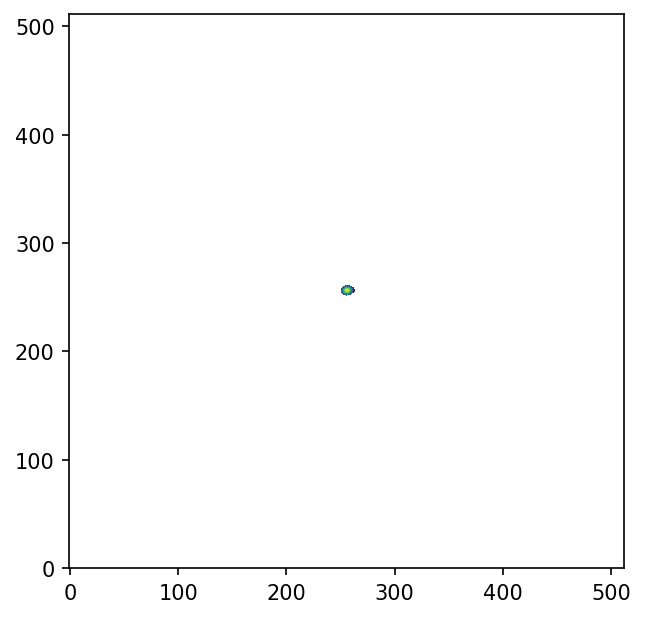

In [6]:
# Set core region
core_reg = fits.open('maser_core.fits')
core_reg_mask = core_reg[0].data == 1
test_map = contimages_ordered_cb[0].with_mask(core_reg_mask)
plt.imshow(test_map[0].value, origin="lower")
plt.show()

In [7]:
# Calculate the peak intensities in each of the continuum images (with central core mask on)
freqs = []
peaks = []
for contimage in contimages_ordered_cb:
    freq = contimage.spectral_axis[0].to(u.GHz) # This is the center freq of the ms
    # peak = np.nanmax(contimage[0].value)*contimage.unit # Peak intensity of the whole image
    peak = np.nanmax(contimage.with_mask(core_reg_mask)[0].value)*contimage[0].unit # Peak intensity of core region
    freqs.append(freq)
    peaks.append(peak)
freqs_vals = np.array([freq.value for freq in freqs])
peaks_vals = np.array([peak.value for peak in peaks])

In [8]:
# for contimage in contimages_ordered_cb:
#     immin = np.nanmin(contimage[0].value)
#     immax = np.nanmax(contimage[0].value)
#     ax = plt.subplot(111, projection = contimage[0].wcs)
#     im = ax.imshow(contimage[0].value, origin = 'lower', cmap='viridis', norm='linear', vmax=0.11*immax, vmin=immin)
#     cbar = plt.colorbar(im, ax=ax)
#     cbar.set_label(f"Brightness temperature [{contimage[0].unit.to_string(format = 'latex_inline')}]")
#     ax.set_ylabel('Declination')
#     ax.set_xlabel('Right ascension') 
#     # Add core contour
#     mask = contimages_ordered[5][0] > 2.*u.mJy/u.beam
#     ax.contour(mask, levels = [0, 1], linewidths=0.75, colors = ['r'])
#     # Put beam on each image
#     pixscale = np.abs((wcs.utils.proj_plane_pixel_area(contimage[0].wcs)**0.5*u.deg).to(u.arcsec))
#     bm = contimage[0].beam
#     bmell = bm.ellipse_to_plot(15, 15, pixscale)
#     bmell.set_facecolor('none')
#     bmell.set_edgecolor('k')
#     ax.add_artist(bmell)
#     # Add center frequency to plot
#     freq = str(round(contimage.spectral_extrema[0].to(u.GHz).value, 2))+' GHz'
#     plt.text(0.02, 0.95, freq, transform=ax.transAxes)
#     # Compute the angle corresponding to some distance in parsecs at the distance of the galactic center
#     from astropy.visualization.wcsaxes import add_scalebar
#     gc_distance = 8.0*u.kpc
#     scalebar_length = 0.25*u.pc
#     scalebar_angle = (scalebar_length / gc_distance).to(u.deg, equivalencies=u.dimensionless_angles())
#     # Add a scale bar
#     add_scalebar(ax, scalebar_angle, label=f"{scalebar_length.value} {scalebar_length.unit}", color="black", frame=True)
#     plt.show()

In [9]:
from scipy.optimize import curve_fit
def linear(x, m, b):
    return m*x + b

In [10]:
# Do a linear fit on the core SED
popt, pcov = curve_fit(linear, freqs_vals, peaks_vals)
slope, intercept = popt[0], popt[1]

In [120]:
from dust_emissivity import fit_sed
tguess, bguess, nguess = 50.*u.K, 1.75, 1e26*u.cm**-2
beam_area = contimages_ordered_cb[0].beam.sr
freqs_ar = [freq.value for freq in freqs]*freqs[0].unit
peaks_ar = [peak.value for peak in peaks]*peaks[0].unit*u.beam/beam_area.value # This only works for peak intensity; we are looking at one pixel, so it's one beam
pars = fit_sed.fit_modified_bb(freqs_ar, peaks_ar, 0.1*peaks_ar, guesses=(tguess, bguess, nguess))
pars

[<Quantity 4.97086412 K>,
 1.7335556541426387,
 <Quantity 7.91161842e+24 1 / cm2>]

In [121]:
from dust_emissivity import blackbody
mbb_fit = blackbody.modified_blackbody(freqs_ar, pars[0], pars[1], pars[2])
mbb_fit

<Quantity [6.26931461e-16, 7.15483138e-16, 8.09957596e-16, 9.09967261e-16,
           9.72216516e-16, 1.80655118e-15, 2.40748497e-15, 8.05455844e-15,
           8.94557168e-15] erg / (cm2 Hz s sr)>

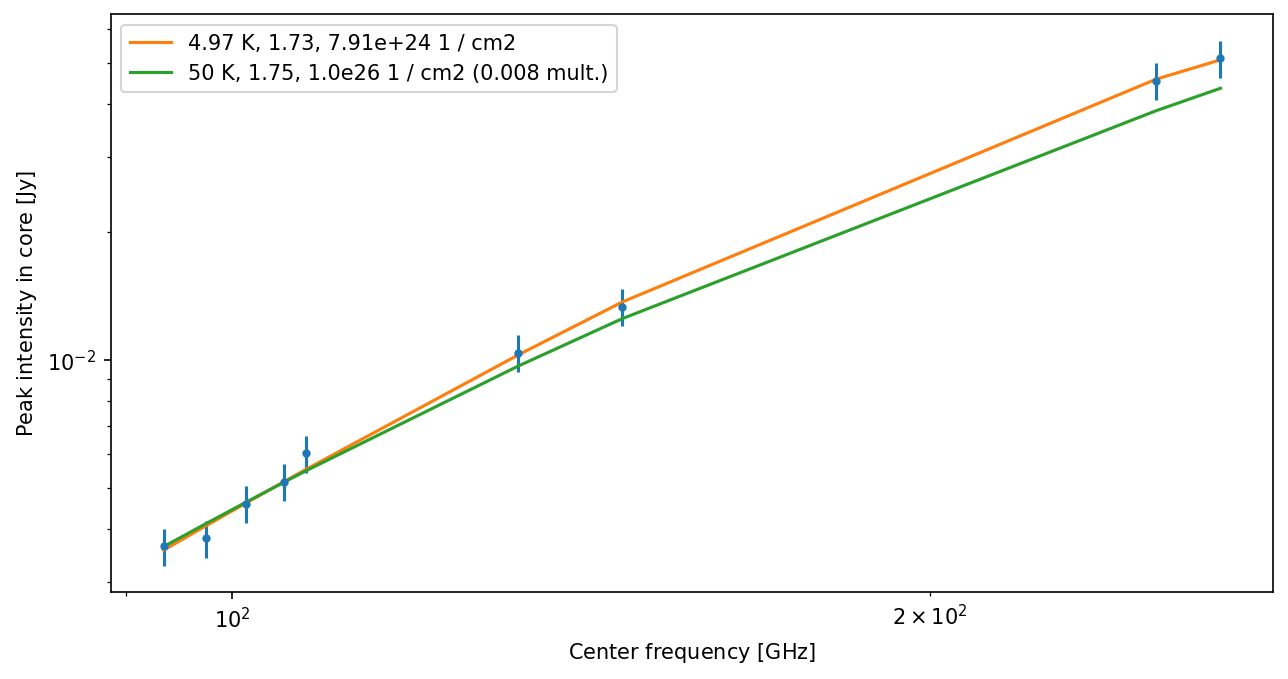

In [122]:
fig = plt.figure(figsize = (10, 5))
plt.errorbar(freqs_vals, peaks_vals, yerr=0.1*peaks_vals, fmt='.', linestyle='')
line_xvals = np.arange(min(freqs_vals), max(freqs_vals))
# plt.plot(line_xvals, linear(line_xvals, slope, intercept), color='tab:orange') # Linear fit
plt.plot(freqs_ar, (mbb_fit*beam_area).to(u.Jy), color='tab:orange', label=f'{pars[0]:0.2f}, {pars[1]:0.2f}, {pars[2]:0.2e}') # Modified blackbody fit
plt.plot(freqs_ar, 0.008*(blackbody.modified_blackbody(freqs_ar, 50*u.K, 1.75, 1.0e26*u.cm**-2)*beam_area).to(u.Jy), color='tab:green', label='50 K, 1.75, 1.0e26 1 / cm2 (0.008 mult.)')
plt.ylabel(f"Peak intensity in core [{peaks_ar[0].unit.to_string(format = 'latex_inline')}]")
plt.xlabel(f"Center frequency [{freqs[0].unit.to_string(format = 'latex_inline')}]")
plt.loglog()
plt.legend()
# plt.xlim(max(freqs_ar.value), min(freqs_ar.value)) # Don't do the astronomer thing; if you're going to do this, change the x-axis to wavelength
plt.show()

In [130]:
def pwr_law(x, a, b):
    return a*(x**b)

In [170]:
popt_lo, pcov_lo = curve_fit(pwr_law, freqs_vals[0:5], peaks_vals[0:5])
popt_lm, pcov_lm = curve_fit(pwr_law, freqs_vals[0:7], peaks_vals[0:7])
popt_md, pcov_md = curve_fit(pwr_law, freqs_vals[5:7], peaks_vals[5:7], p0=(3e-10,3))
popt_mh, pcov_mh = curve_fit(pwr_law, freqs_vals[5:9], peaks_vals[5:9], p0=(3e-10,3))
popt_hi, pcov_hi = curve_fit(pwr_law, freqs_vals[7:9], peaks_vals[7:9], p0=(3e-10,3))

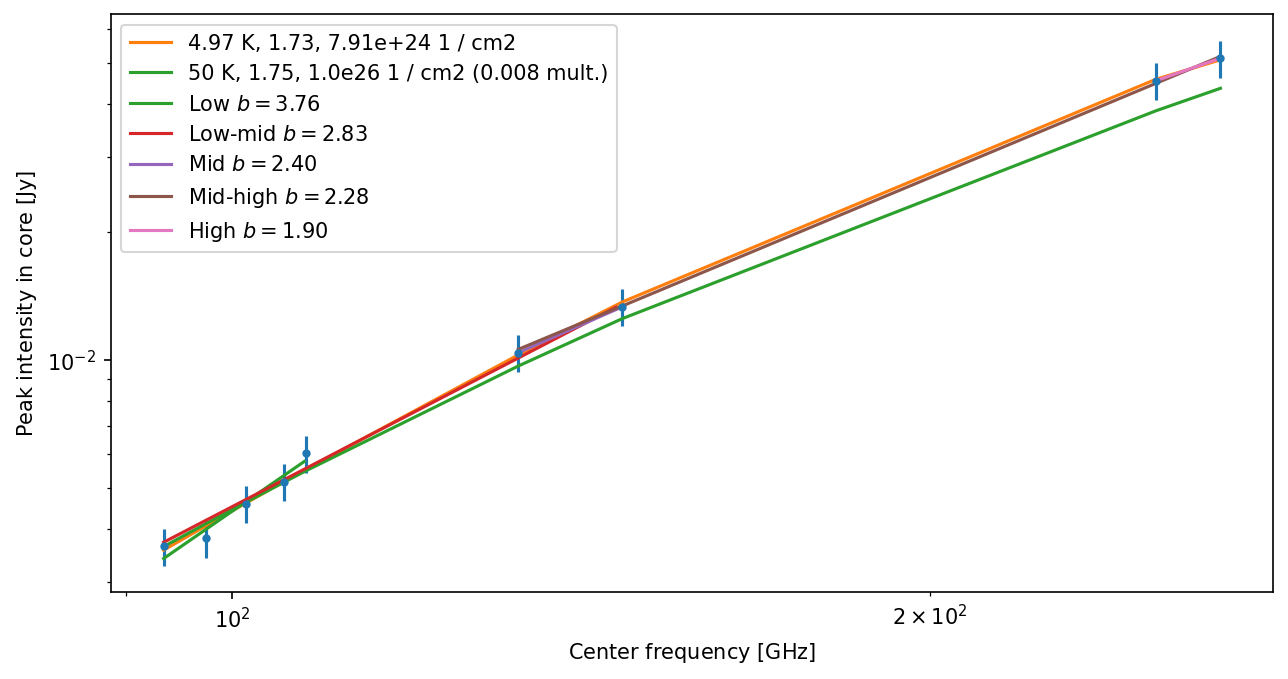

In [176]:
fig = plt.figure(figsize = (10, 5))
plt.errorbar(freqs_vals, peaks_vals, yerr=0.1*peaks_vals, fmt='.', linestyle='')
line_xvals = np.arange(min(freqs_vals), max(freqs_vals))
# plt.plot(line_xvals, linear(line_xvals, slope, intercept), color='tab:orange') # Linear fit
plt.plot(freqs_ar, (mbb_fit*beam_area).to(u.Jy), label=f'{pars[0]:0.2f}, {pars[1]:0.2f}, {pars[2]:0.2e}') # Modified blackbody fit
plt.plot(freqs_ar, 0.008*(blackbody.modified_blackbody(freqs_ar, 50*u.K, 1.75, 1.0e26*u.cm**-2)*beam_area).to(u.Jy), color='tab:green', label='50 K, 1.75, 1.0e26 1 / cm2 (0.008 mult.)')
line_xvals_lo = np.arange(min(freqs_vals[0:5]), max(freqs_vals[0:5]))
plt.plot(line_xvals_lo, pwr_law(line_xvals_lo,popt_lo[0],popt_lo[1]), label=f'Low $b = {popt_lo[1]:0.2f}$') # Power law fit
line_xvals_lm = np.arange(min(freqs_vals[0:7]), max(freqs_vals[0:7]))
plt.plot(line_xvals_lm, pwr_law(line_xvals_lm,popt_lm[0],popt_lm[1]), label=f'Low-mid $b = {popt_lm[1]:0.2f}$') # Power law fit
line_xvals_md = np.arange(min(freqs_vals[5:7]), max(freqs_vals[5:7]))
plt.plot(line_xvals_md, pwr_law(line_xvals_md,popt_md[0],popt_md[1]), label=f'Mid $b = {popt_md[1]:0.2f}$') # Power law fit
line_xvals_mh = np.arange(min(freqs_vals[5:9]), max(freqs_vals[5:9]))
plt.plot(line_xvals_mh, pwr_law(line_xvals_mh,popt_mh[0],popt_mh[1]), label=f'Mid-high $b = {popt_mh[1]:0.2f}$') # Power law fit
line_xvals_hi = np.arange(min(freqs_vals[7:9]), max(freqs_vals[7:9]))
plt.plot(line_xvals_hi, pwr_law(line_xvals_hi,popt_hi[0],popt_hi[1]), label=f'High $b = {popt_hi[1]:0.2f}$') # Power law fit
plt.ylabel(f"Peak intensity in core [{peaks_ar[0].unit.to_string(format = 'latex_inline')}]")
plt.xlabel(f"Center frequency [{freqs[0].unit.to_string(format = 'latex_inline')}]")
plt.loglog()
plt.legend()
# plt.xlim(max(freqs_ar.value), min(freqs_ar.value)) # Don't do the astronomer thing; if you're going to do this, change the x-axis to wavelength
plt.show()

# Frown

In [14]:
contimages_ordered_cb_Jysr = [contimage.to(u.Jy/u.sr) for contimage in contimages_ordered_cb]

388

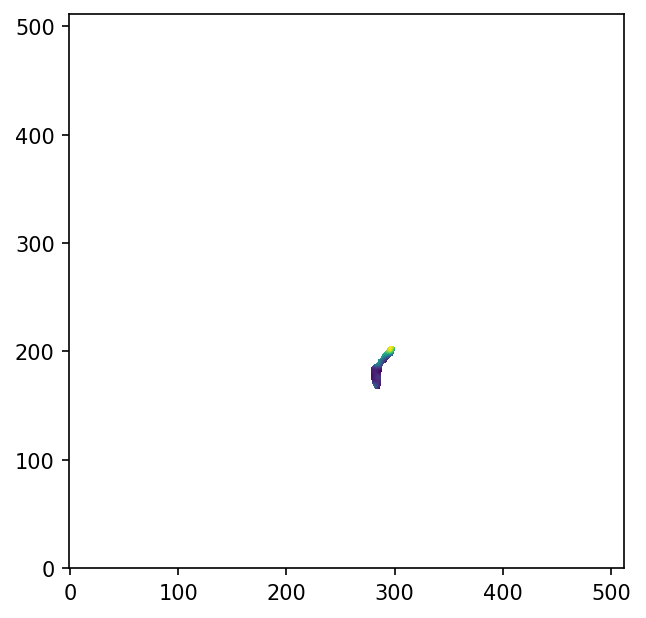

In [19]:
# Set frown region
diff_reg = fits.open('diffuse_regions.fits')
diff_reg_mask = diff_reg[0].data == 1
array, footprint = reproject_interp((diff_reg_mask, diff_reg[0].header), contimages_ordered_cb_Jysr[0].wcs.celestial, shape_out=(contimages_ordered_cb_Jysr[0].shape[1], 
                                                                                                                                 contimages_ordered_cb_Jysr[0].shape[2]))
array[np.isnan(array)] = 0
# plt.imshow(array, origin="lower")
test_map = contimages_ordered_cb_Jysr[0].with_mask(array > 0)
plt.imshow(test_map[0].value, origin="lower")

In [91]:
# Take spatially-averaged intensities in each of the continuum images (with frown mask on)
freqs = []
ints = []
for contimage in contimages_ordered_cb_Jysr:
    freq = contimage.spectral_axis[0].to(u.GHz) # This is the center freq of the ms
    int_avg = np.nanmean(contimage.with_mask(array > 0)[0].value) * u.Jy / u.sr # Average intensity in frown region in Jy/sr
    pix_area = abs(test_map.header['CDELT1']*u.deg*test_map.header['CDELT2']*u.deg).to(u.sr) # Area of pixel in sr
    ap_area = (array > 0).sum() * pix_area # Area of aperture in sr
    int_avg_Jy = int_avg * ap_area # Average intensity in Jy
    freqs.append(freq)
    ints.append(int_avg_Jy)
freqs_vals = np.array([freq.value for freq in freqs])
ints_vals = np.array([int_avg.value for int_avg in ints])

In [97]:
# Do a power law fit on the frown SED
popt, pcov = curve_fit(pwr_law, freqs_vals, ints_vals)

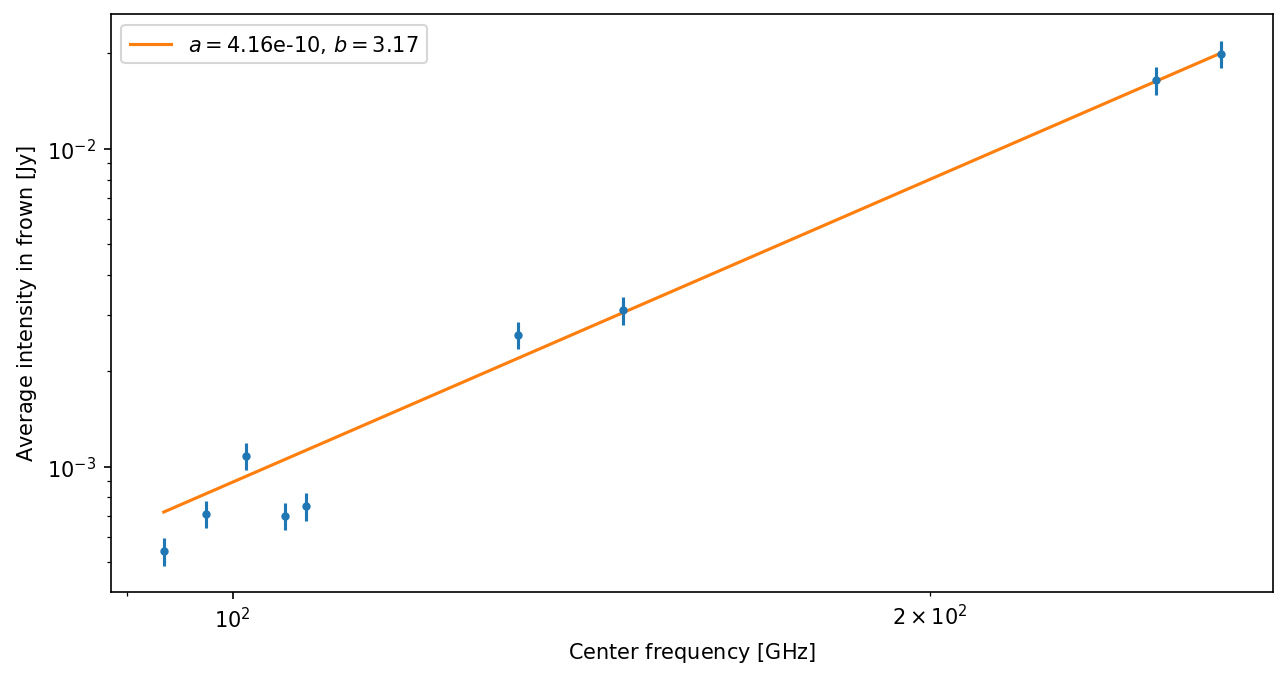

In [109]:
fig = plt.figure(figsize = (10, 5))
plt.errorbar(freqs_vals, ints_vals, yerr=0.1*ints_vals, fmt='.', linestyle='')
line_xvals = np.arange(min(freqs_vals), max(freqs_vals))
plt.plot(line_xvals, pwr_law(line_xvals,popt[0],popt[1]), color='tab:orange', label=f'$a = ${popt[0]:0.2e}, $b = {popt[1]:0.2f}$') # Power law fit
plt.ylabel(f"Average intensity in frown [{ints[0].unit.to_string(format = 'latex_inline')}]")
plt.xlabel(f"Center frequency [{freqs[0].unit.to_string(format = 'latex_inline')}]")
plt.loglog() 
plt.legend()
plt.show()